# Prediction based regularization (PROSIT) for iterative reconstructions: Phantom study

The reconstruction is definded as

$$\min_x \frac{1}{2} \| \underbrace{P F S}_{A} x - y \|_2^2 + \frac{\lambda}{2} \| x - p \|_2^2$$

with:
- $P$ as the (under)sampling operator
- $F$ as the Fourier operator
- $S$ as the sensitivity map operator
- $x$ as the reconstructed image
- $y$ as the measured (undersampled) k-space
- $p$ as the predicted image

## Setup

In [1]:
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

N = 256  # image size
ImgShape = (N, N)
NCoils = 4  # number of coils
KspShape = (NCoils, N, N)
Acc = 16  # undersampling factor



## Create phantom and undersampled k-space

In [2]:
# create (complex-valued) phantom
Pht = sp.shepp_logan(ImgShape)

# create coil-wise k-space
Maps = mr.birdcage_maps(KspShape)
Ksp = sp.fft(Pht * Maps)

# create undersampled k-space
Mask = mr.poisson(ImgShape, Acc, 30, (24, 24))
KspUnder = Ksp * Mask
pl.ImagePlot(KspUnder, z=0, mode='l')

<Figure size 640x480 with 1 Axes>

## ESPIRiT 

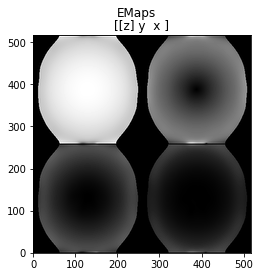

In [3]:
# estimate maps using ESPIRIT from the undersampled k-space
EMaps = mr.app.EspiritCalib(KspUnder).run()
pl.ImagePlot(EMaps, z=0, title='EMaps')

## Linear operators

In [4]:
# set-up LinOps
F = sp.linop.FFT(KspShape, axes=(-1, -2))
S = sp.linop.Multiply(ImgShape, EMaps)
P = sp.linop.Multiply(KspUnder.shape, Mask)
A = P * F * S

## Create several predictions/priors

In [5]:
# Create several Priors
# empty prediction / all zeros
pZero = np.zeros((N, N))
# noisy fully sampled image
pGrd = S.H * F.H * Ksp
# rotated version
pRot = np.transpose(pGrd)
# shifted by 10 pixels
pTrans = np.roll(pGrd, 10, axis=1)
# only the edge is kept
pEdge = pGrd.copy()
pEdge[abs(pEdge) < 0.5] = 0
# "bad prediction"
pMissing = pGrd.copy()
pMissing[(abs(pMissing) > 0.15) & (abs(pMissing) < 0.4)] = 0.25

## Run PROSIT reconstructions

In [6]:
# PROSIT reconstructions with various priors
Lambda = 0.01
MaxIter = 30

rGrd = sp.app.LinearLeastSquares(A, KspUnder, alg_name='GradientMethod', alpha=1, max_iter=MaxIter, max_power_iter=1,
                                 proxg=sp.prox.L2Reg(ImgShape, lamda=Lambda, y=pGrd)).run()
rZero = sp.app.LinearLeastSquares(A, KspUnder, alg_name='GradientMethod', alpha=1, max_iter=MaxIter, max_power_iter=1,
                                  proxg=sp.prox.L2Reg(ImgShape, lamda=Lambda, y=pZero)).run()
rRot = sp.app.LinearLeastSquares(A, KspUnder, alg_name='GradientMethod', alpha=1, max_iter=MaxIter, max_power_iter=1,
                                 proxg=sp.prox.L2Reg(ImgShape, lamda=Lambda, y=pRot)).run()
rTrans = sp.app.LinearLeastSquares(A, KspUnder, alg_name='GradientMethod', alpha=1, max_iter=MaxIter, max_power_iter=1,
                                   proxg=sp.prox.L2Reg(ImgShape, lamda=Lambda, y=pTrans)).run()
rEdge = sp.app.LinearLeastSquares(A, KspUnder, alg_name='GradientMethod', alpha=1, max_iter=MaxIter, max_power_iter=1,
                                  proxg=sp.prox.L2Reg(ImgShape, lamda=Lambda, y=pEdge)).run()
rMissing = sp.app.LinearLeastSquares(A, KspUnder, alg_name='GradientMethod', alpha=1, max_iter=MaxIter,
                                     max_power_iter=1,
                                     proxg=sp.prox.L2Reg(ImgShape, lamda=Lambda, y=pMissing)).run()

## Plot results

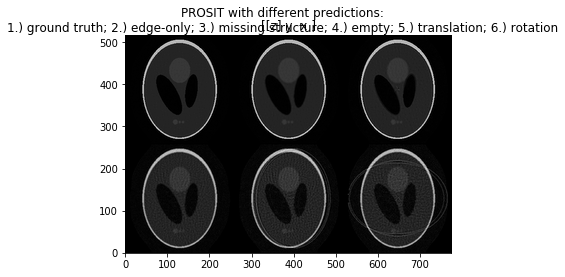

In [7]:
Res = np.stack((rZero, rTrans, rRot, rGrd, rEdge, rMissing))


pl.ImagePlot(Res, z=0, title='PROSIT with different predictions:\n1.) ground truth; 2.) edge-only; 3.) missing '
                             'structure; 4.) empty; 5.) translation; 6.) rotation')